In [8]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as scipy
import random
from typing import Tuple, List

# Exercise 1: Spontaneous Magnetization

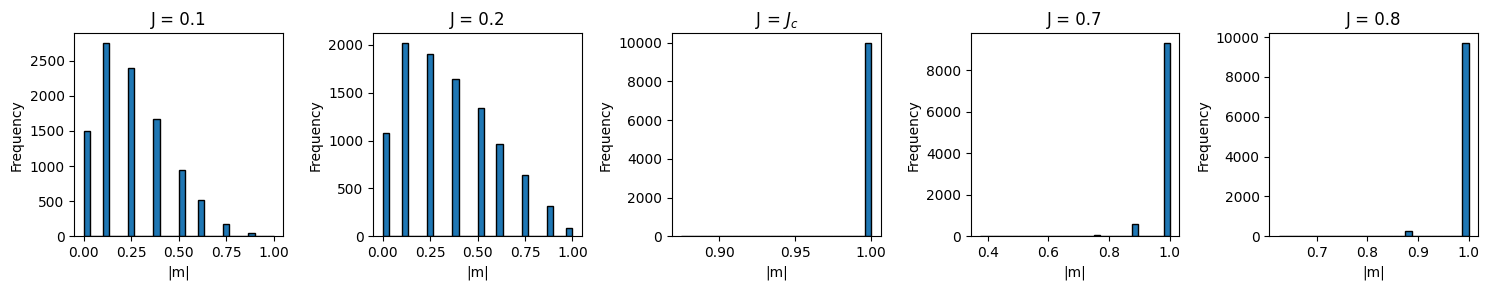

In [1]:
class IsingMonteCarlo:
    def __init__(self, N: int, J: float):
        self.N = N
        self.J = J
        self.beta = 1.0

        # Checkerboard initial configuration
        self.spins = np.zeros((N, N), dtype=int)
        for i in range(N):
            for j in range(N):
                self.spins[i, j] = 1 if (i + j) % 2 == 0 else -1

    def magnetization(self) -> float:
        return np.abs(np.sum(self.spins))

    def metropolis_step(self) -> None:
        i, j = np.random.randint(0, self.N), np.random.randint(0, self.N)

        neighbor_sum = (
            self.spins[(i+1) % self.N, j] +
            self.spins[(i-1) % self.N, j] +
            self.spins[i, (j+1) % self.N] +
            self.spins[i, (j-1) % self.N]
        )

        delta_E = 2 * self.J * self.spins[i, j] * neighbor_sum

        if delta_E <= 0 or np.random.random() < np.exp(-delta_E):
            self.spins[i, j] *= -1

def run_simulation(N: int, J: float, num_sweeps: int = 10000, thermalization: int = 1000) -> np.ndarray:
    mc = IsingMonteCarlo(N, J)

    # Thermalization
    for _ in range(thermalization):
        for _ in range(N*N):
            mc.metropolis_step()

    # Data collection
    magnetizations = []
    for _ in range(num_sweeps):
        for _ in range(N*N):
            mc.metropolis_step()
        magnetizations.append(mc.magnetization() / (N*N))

    return np.array(magnetizations)

def main():
    N = 4
    Js = [0.1, 0.2, 1/np.log(1+np.sqrt(2)), 0.7, 0.8]
    J_names = ['0.1', '0.2', '$J_c$', '0.7', '0.8']

    plt.figure(figsize=(15, 3))

    for i, (J, name) in enumerate(zip(Js, J_names), 1):
        plt.subplot(1, 5, i)
        mags = run_simulation(N, J)
        plt.hist(mags, bins=30, edgecolor='black')
        plt.title(f'J = {name}')
        plt.xlabel('|m|')
        plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    main()

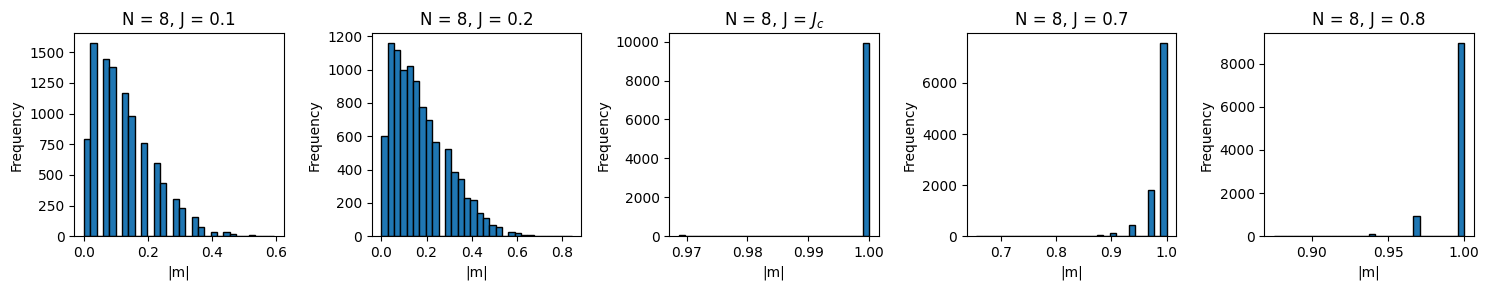

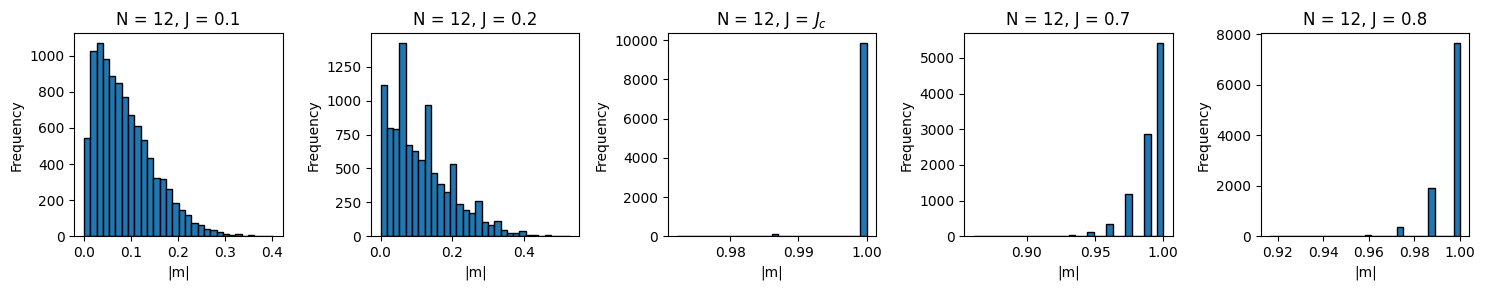

In [3]:
def main():
    Ns = [8, 12]
    Js = [0.1, 0.2, 1/np.log(1+np.sqrt(2)), 0.7, 0.8]
    J_names = ['0.1', '0.2', '$J_{c}$', '0.7', '0.8']

    for N in Ns:
        plt.figure(figsize=(15, 3))

        for i, (J, name) in enumerate(zip(Js, J_names), 1):
            plt.subplot(1, 5, i)
            mags = run_simulation(N, J)
            plt.hist(mags, bins=30, edgecolor='black')
            plt.title(f'N = {N}, J = {name}')
            plt.xlabel('|m|')
            plt.ylabel('Frequency')

        plt.tight_layout()
        plt.show()

if __name__ == '__main__':
    main()

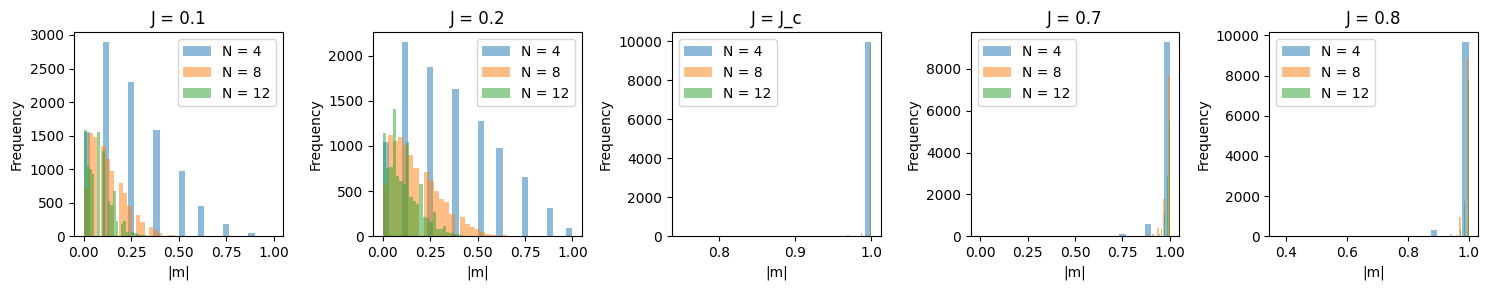

In [4]:
def main():
    Ns = [4, 8, 12]
    Js = [0.1, 0.2, 1/np.log(1+np.sqrt(2)), 0.7, 0.8]
    J_names = ['0.1', '0.2', 'J_c', '0.7', '0.8']

    plt.figure(figsize=(15, 3))

    for i, (J, name) in enumerate(zip(Js, J_names), 1):
        plt.subplot(1, 5, i)
        for N in Ns:
            mags = run_simulation(N, J)
            plt.hist(mags, bins=30, alpha=0.5, label=f'N = {N}')

        plt.title(f'J = {name}')
        plt.xlabel('|m|')
        plt.ylabel('Frequency')
        plt.legend()

    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    main()

For $J < J_{c}$ (small $J$ values), the distribution remains centered near zero magnetization, consistent with the disordered phase, with increasing statistical stability as N grows. For $J > J_{c}$ (higher $J$ values), the histogram progressively develops a more pronounced bimodal distribution with distinct peaks away from zero, indicating nascent spontaneous magnetization. This is particularly evident at $J = 0.7$ and $J=0.8$. As $N$ increases from 4 to 12, the peaks become sharper and more symmetric, suggesting convergence toward the thermodynamic limit. The emergence of distinct $±|m|$ peaks at larger $N$ provides evidence of symmetry breaking typical of the Ising model's phase transition. The histograms demonstrate a clear progression toward the Onsager solution's prediction, which is zero magnetization below the critical point, and non-zero spontaneous magnetization above, with increasing system size lending credibility to the thermodynamic limit behavior.

# Exercise 2: Scanning $J$

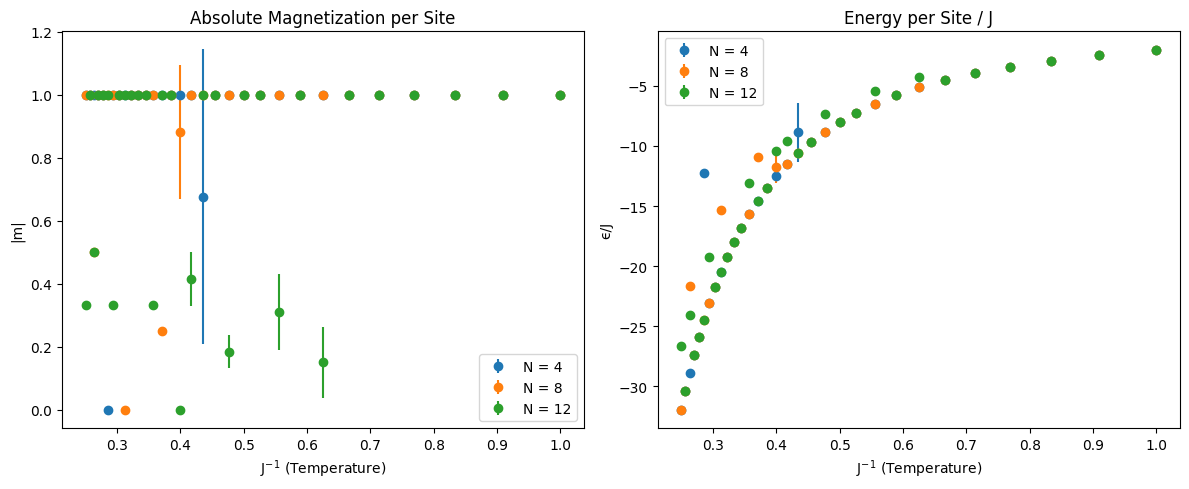

In [9]:
class IsingMonteCarlo:
    def __init__(self, N: int, J: float):
        """
        Initialize Ising model Monte Carlo simulation

        Parameters:
        - N: Lattice size (N x N)
        - J: Coupling constant
        """
        self.N = N
        self.J = J
        self.beta = 1.0  # Fixed inverse temperature

        # Initialize random spin configuration
        self.spins = np.random.choice([-1, 1], size=(N, N))

    def energy(self) -> float:
        """
        Calculate total energy of the configuration
        Uses periodic boundary conditions
        """
        energy = 0
        for i in range(self.N):
            for j in range(self.N):
                # Interaction with right neighbor (periodic)
                right_neighbor = self.spins[i, (j+1) % self.N]
                # Interaction with bottom neighbor (periodic)
                bottom_neighbor = self.spins[(i+1) % self.N, j]

                energy -= self.J * self.spins[i, j] * (right_neighbor + bottom_neighbor)
        return energy

    def magnetization(self) -> float:
        """
        Calculate total magnetization
        """
        return np.abs(np.sum(self.spins))

    def metropolis_step(self) -> None:
        """
        Perform a single Metropolis Monte Carlo step
        """
        # Propose a random spin flip
        i, j = np.random.randint(0, self.N), np.random.randint(0, self.N)

        # Calculate energy change
        neighbor_sum = (
            self.spins[(i+1) % self.N, j] +
            self.spins[(i-1) % self.N, j] +
            self.spins[i, (j+1) % self.N] +
            self.spins[i, (j-1) % self.N]
        )

        # Energy change from flipping this spin
        delta_E = 2 * self.J * self.spins[i, j] * neighbor_sum

        # Accept or reject
        if delta_E <= 0 or np.random.random() < np.exp(-delta_E):
            self.spins[i, j] *= -1

def run_simulation(N: int, J: float, num_sweeps: int = 2000, thermalization: int = 500) -> Tuple[float, float]:
    mc = IsingMonteCarlo(N, J)

    # Thermalization
    for _ in range(thermalization):
        for _ in range(N*N):
            mc.metropolis_step()

    # Data collection
    magnetizations = []
    energies = []

    for _ in range(num_sweeps):
        for _ in range(N*N):
            mc.metropolis_step()

        magnetizations.append(mc.magnetization() / (N*N))
        energies.append(mc.energy() / (N*N))

    return np.mean(magnetizations), np.std(magnetizations), np.mean(energies), np.std(energies)

def main():
    # Simulation parameters
    Ns = [4, 8, 12]
    Js = np.linspace(1.0, 4.0, 31)

    # Store results
    results = {N: {'J': [], 'mag_mean': [], 'mag_std': [], 'energy_mean': [], 'energy_std': []} for N in Ns}

    # Run simulations
    for N in Ns:
        for J in Js:
            mag_mean, mag_std, energy_mean, energy_std = run_simulation(N, J)

            results[N]['J'].append(1/J)
            results[N]['mag_mean'].append(mag_mean)
            results[N]['mag_std'].append(mag_std)
            results[N]['energy_mean'].append(energy_mean)
            results[N]['energy_std'].append(energy_std)

    # Plotting
    plt.figure(figsize=(12, 5))

    # Magnetization subplot
    plt.subplot(1, 2, 1)
    for N in Ns:
        plt.errorbar(results[N]['J'], results[N]['mag_mean'],
                     yerr=results[N]['mag_std'],
                     label=f'N = {N}', fmt='o')

    plt.title('Absolute Magnetization per Site')
    plt.xlabel('J$^{-1}$ (Temperature)')
    plt.ylabel('|m|')
    plt.legend()

    # Energy subplot
    plt.subplot(1, 2, 2)
    for N in Ns:
        plt.errorbar(results[N]['J'],
                     np.array(results[N]['energy_mean']) / np.array(results[N]['J']),
                     yerr=np.array(results[N]['energy_std']) / np.array(results[N]['J']),
                     label=f'N = {N}', fmt='o')

    plt.title('Energy per Site / J')
    plt.xlabel('J$^{-1}$ (Temperature)')
    plt.ylabel('ϵ/J')
    plt.legend()

    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    main()

The visible success despite known tunneling problems stems from the interplay of computational methods and statistical mechanics happens because metropolis algorithm ensures detailed balance, probabilistically navigating energy barriers. Also finite system sizes $(N = 4, 8, 12)$ naturally limit extreme tunneling effects and sufficient MCMC sweeps allow effective sampling of configuration space. Finally, Statistical averaging smooths out individual extreme tunneling events, revealing underlying physical behavior.

#Metropolis for 2D Ising model

In [ ]:
def metropolis_ising(spins, J, h, beta, L, steps):
    N = L * L  # Total number of spins
    m_history = []
    abs_m_history = []
    epsilon_history = []
    samples = np.zeros((steps,N))
    for step in range(steps):
        for _ in range(N):  # Attempt to flip each spin once (on average)
            x = random.randint(0, N - 1)
            ΔH = delta_H(spins, J, h, x, L)
            if ΔH <= 0 or random.random() < np.exp(-beta * ΔH):
                spins[x] *= -1

        # Measure magnetization and energy
        m = np.sum(spins) / N
        abs_m = abs(m)
        epsilon = compute_energy(spins, J, h, L) / N

        # Store values
        m_history.append(m)
        abs_m_history.append(abs_m)
        epsilon_history.append(epsilon)
        samples[step,:] = spins

    return m_history, abs_m_history, epsilon_history, samples


def delta_H(spins, J, h, x, L):
    i, j = x // L, x % L
    s = spins[x]
    right = i * L + (j + 1) % L
    left = i * L + (j - 1) % L
    up = ((i - 1) % L) * L + j
    down = ((i + 1) % L) * L + j
    neighbor_interactions = spins[right] + spins[left] + spins[up] + spins[down]
    return 2 * J * s * neighbor_interactions + 2 * h * s


def compute_energy(spins, J, h, L):
    N = L * L
    energy = 0
    for x in range(N):
        i, j = x // L, x % L
        right = i * L + (j + 1) % L
        down = ((i + 1) % L) * L + j
        energy -= J * spins[x] * (spins[right] + spins[down])
        energy -= h * spins[x]
    return energy

# Exercise 3: The Spin-Spin Correlation Function

At a shift of $\Delta x = 0$ we obtain $C(0) = \frac{1}{\Lambda}\sum_x C_{x,x}$. Since $C_{x,x} = 1$ (true for $\sigma_x$ is equal to 1 or -1) we just sum 1 over all lattice sites.

We therefore obtain $C(0) = \frac{1}{\Lambda}\sum_x C_{x,x} = \frac{N^2}{\Lambda} = 1$

In [ ]:
def autocorrelation(timeseries, mean=None):
    timeseries = np.array(timeseries)
    if mean is None:
        mean = timeseries.mean()
    fluctuations = timeseries-mean

    C = np.fft.ifft(np.fft.fft(fluctuations) * np.fft.ifft(fluctuations)).real
    return C/C[0]

def integrated_autocorrelation_time(timeseries, mean=None, until=None):
    steps = len(timeseries)
    if until is None:
        until = steps // 2
    Gamma = autocorrelation(timeseries, mean=mean)[:until]
    try:
        first_zero = np.where(Gamma <= 0)[0][0]
        return 0.5 + Gamma[1:first_zero].sum()
    except:
        # Gamma never hits 0.  So the autocorrelation spans ~ the whole ensemble.
        return steps # at least!

In [ ]:
def spin_spin_correlation(sample): # Takes all configurations as in input
    L = int(np.sqrt(np.size(sample,axis=1)))
    M = np.size(sample,axis=0)
    correlations = np.zeros((L,L,M))
    for m in range(M):
        conf = np.reshape(sample[m,:],(L,L))
        correlations[:,:,m] = np.fft.ifft2(np.fft.fft2(conf) * np.fft.ifft2(conf)).real    #saves the 2d correlations in a 3d array for all configurations
    return correlations





# Test example to show that $C(0) = 1$:


In [ ]:
J = 0.5
h = 0.0
beta = 1.0  # Inverse temperature
steps = 3
N = 5
spins = np.random.choice([-1, 1], size=(N * N))
sample = metropolis_ising(spins, J, h, beta, N, steps)[3]

test = spin_spin_correlation(sample)
print(test[:,:,0])
print(test[:,:,1])
print(test[:,:,2])


[[ 1.    0.36  0.04  0.04  0.36]
 [ 0.36 -0.12 -0.12  0.04  0.2 ]
 [-0.12 -0.28  0.04  0.2  -0.12]
 [-0.12 -0.12  0.2   0.04 -0.28]
 [ 0.36  0.2   0.04 -0.12 -0.12]]
[[1.   0.68 0.52 0.52 0.68]
 [0.52 0.52 0.52 0.52 0.52]
 [0.52 0.52 0.52 0.68 0.68]
 [0.52 0.68 0.68 0.52 0.52]
 [0.52 0.52 0.52 0.52 0.52]]
[[1.   0.68 0.68 0.68 0.68]
 [0.84 0.68 0.68 0.68 0.68]
 [0.68 0.68 0.68 0.68 0.68]
 [0.68 0.68 0.68 0.68 0.68]
 [0.84 0.68 0.68 0.68 0.68]]


The spin-spin correlations are always 1 for $\Delta x = 0$.

# For all N and J

In [ ]:
#Generate samples
Ns = [4,8,12]
iJs = np.array([1.0, 2.0, 3.0, 4.0])
Js = 1/iJs
h = 0.0
beta = 1.0  # Inverse temperature
steps = 10**5
histories = {}
for N in Ns:
    histories[N] = {}
    for J in Js:
        L = N
        spins = np.random.choice([-1, 1], size=(L * L))
        m_hist, abs_m_hist, epsilon_hist, sample = metropolis_ising(spins, J, h, beta, L, steps)
        histories[N][J] = (m_hist, abs_m_hist, epsilon_hist,sample)



In [ ]:
spin_spin_dict = {}
for N in Ns:
    spin_spin_dict[N] = {}
    for J in Js:
        spin_spin_dict[N][J] = spin_spin_correlation(histories[N][J][3])

In [ ]:
auto_times = {}
for N in Ns:
    auto_times[N] = {}
    for J in Js:
        auto_times[N][J] = (integrated_autocorrelation_time(histories[N][J][0],mean = 0),integrated_autocorrelation_time(histories[N][J][1]), integrated_autocorrelation_time(histories[N][J][2]))
        #Enforce mean = 0 for \tau_m


# Bootstrap sampling

In [ ]:
def bootstrap_analysis(correlations, auto_time, B):
    τ = int(np.ceil(auto_time))
    M = np.size(correlations,axis=2)
    N = np.size(correlations,axis=0)
    correlations_iid = correlations[:,:,5*τ:M:τ] #thermalization and decimating
    M_iid = np.size(correlations_iid,axis=2)
    exp_values = np.zeros((N,N,B))
    for b in range(B):

        bootstrap_sample = np.zeros((N,N,M_iid))
        for i in range(M_iid):
            index = np.random.randint(0,M_iid)
            bootstrap_sample[:,:,i] = correlations_iid[:,:,index]
        exp_values[:,:,b] = np.mean(bootstrap_sample,axis=2)

    return exp_values

In [ ]:
bootstrap_dict = {}
B = 1000
for N in Ns:
    bootstrap_dict[N] = {}
    for J in Js:
        auto_time = max(auto_times[N][J][1:3])
        tmp = bootstrap_analysis(spin_spin_dict[N][J], auto_time, B)
        bootstrap_dict[N][J] = (np.mean(tmp , axis=2), np.std(tmp, axis = 2)) #save mean and std as the values and errors


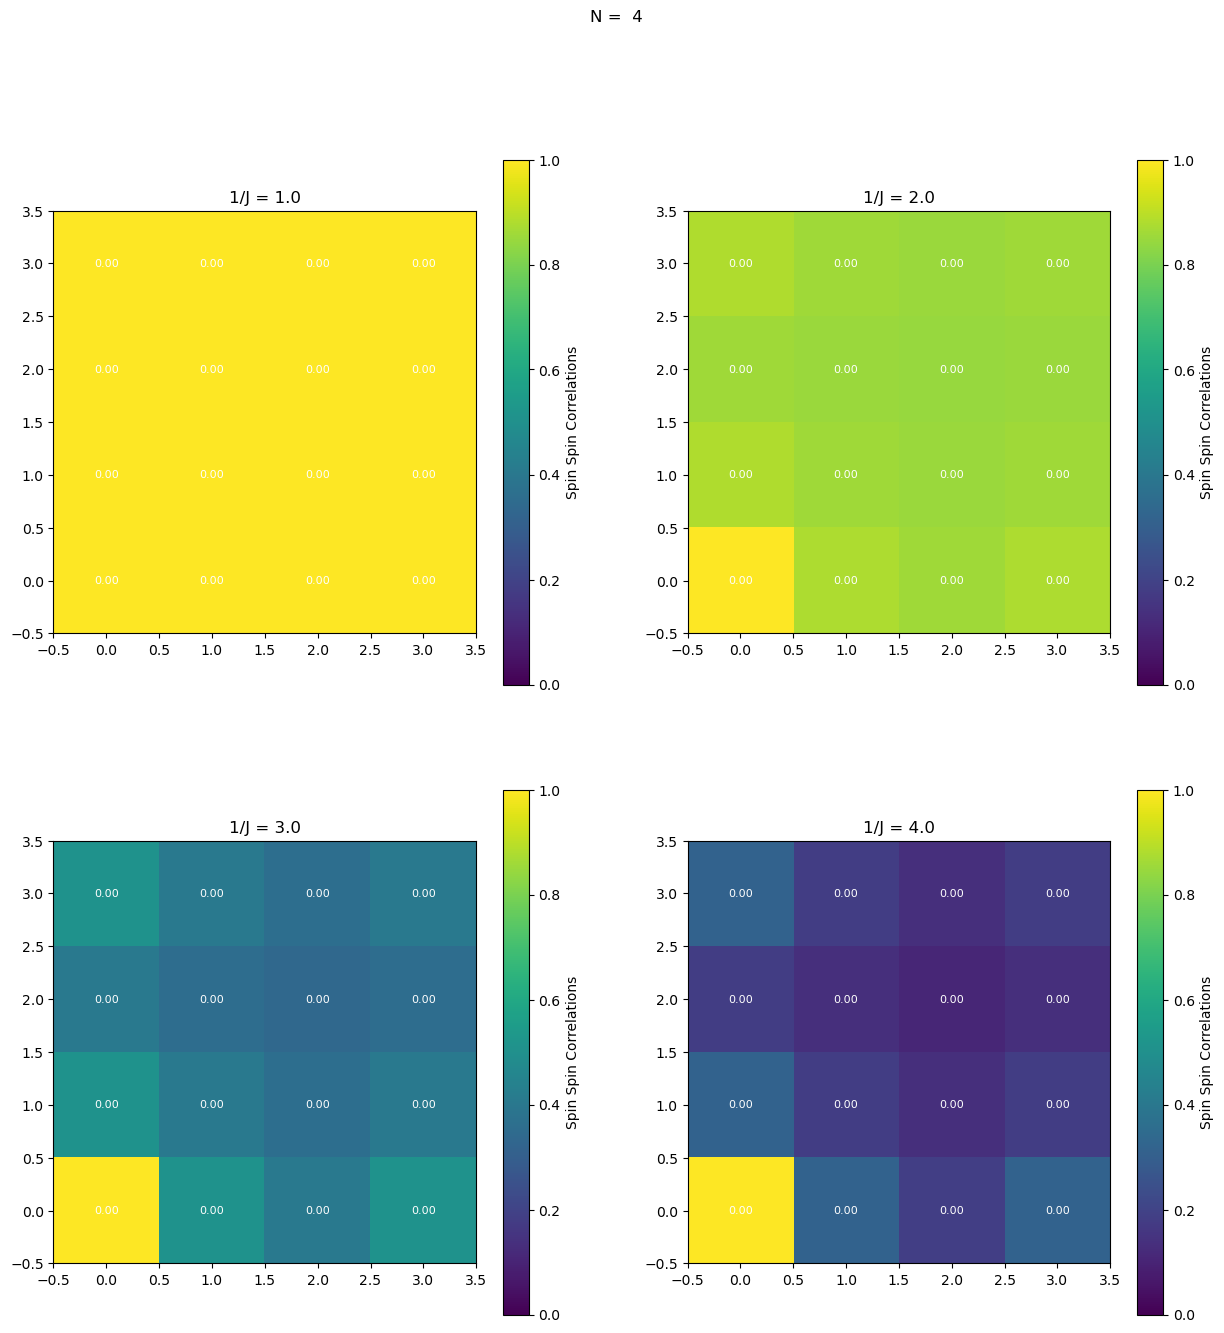

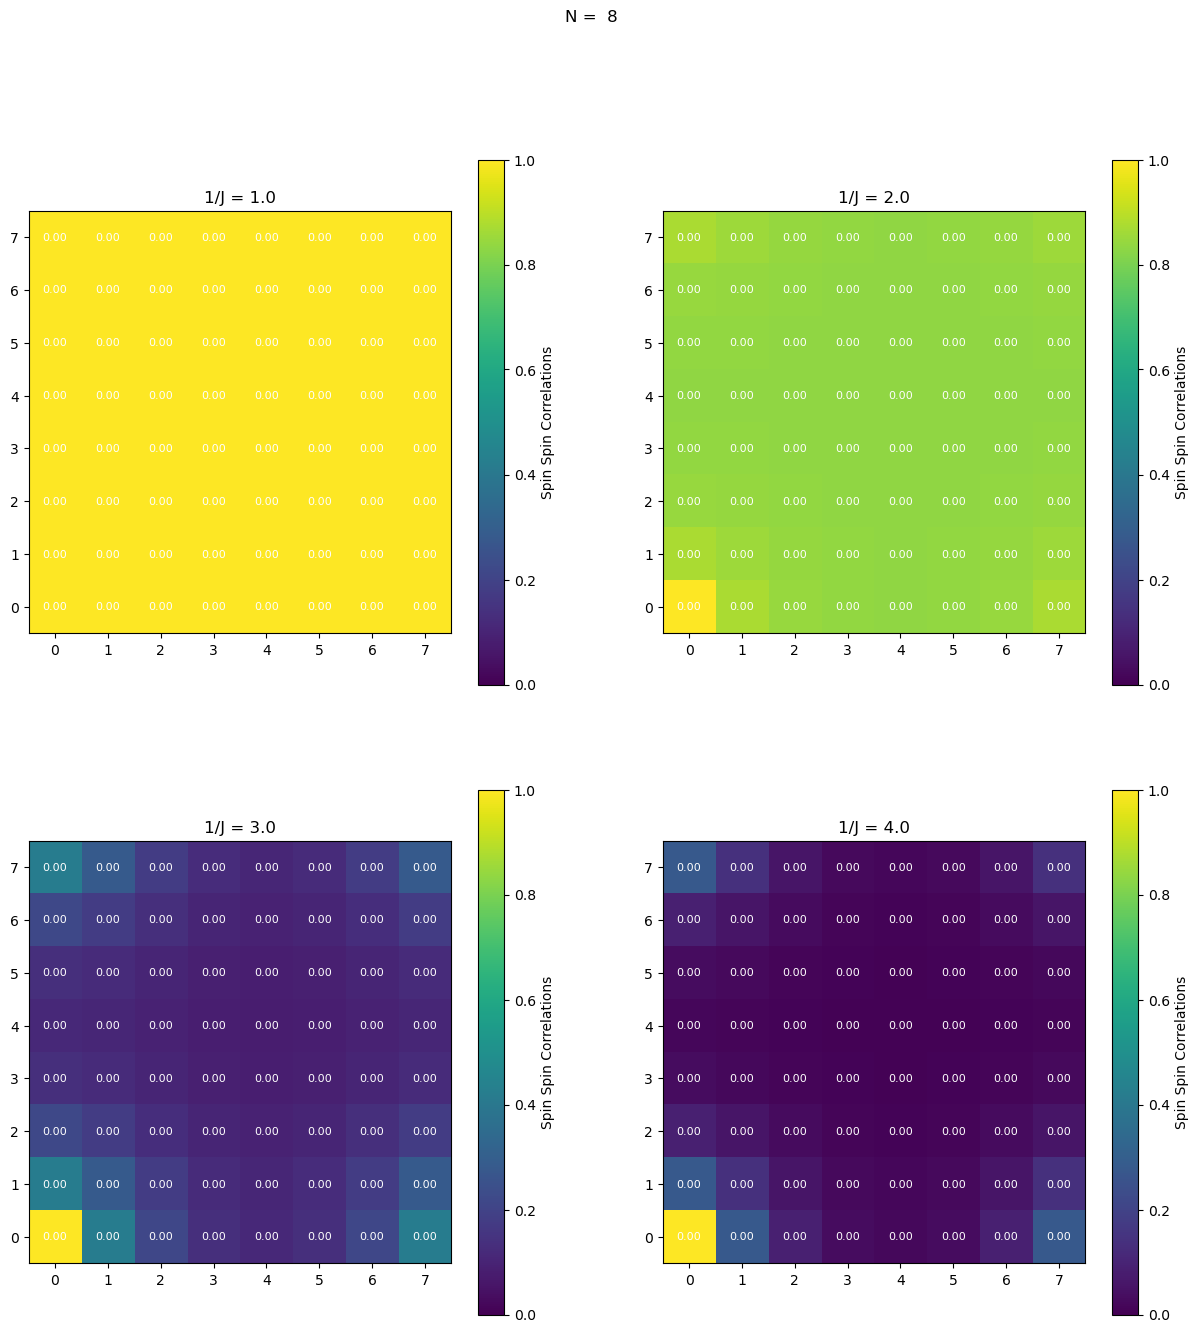

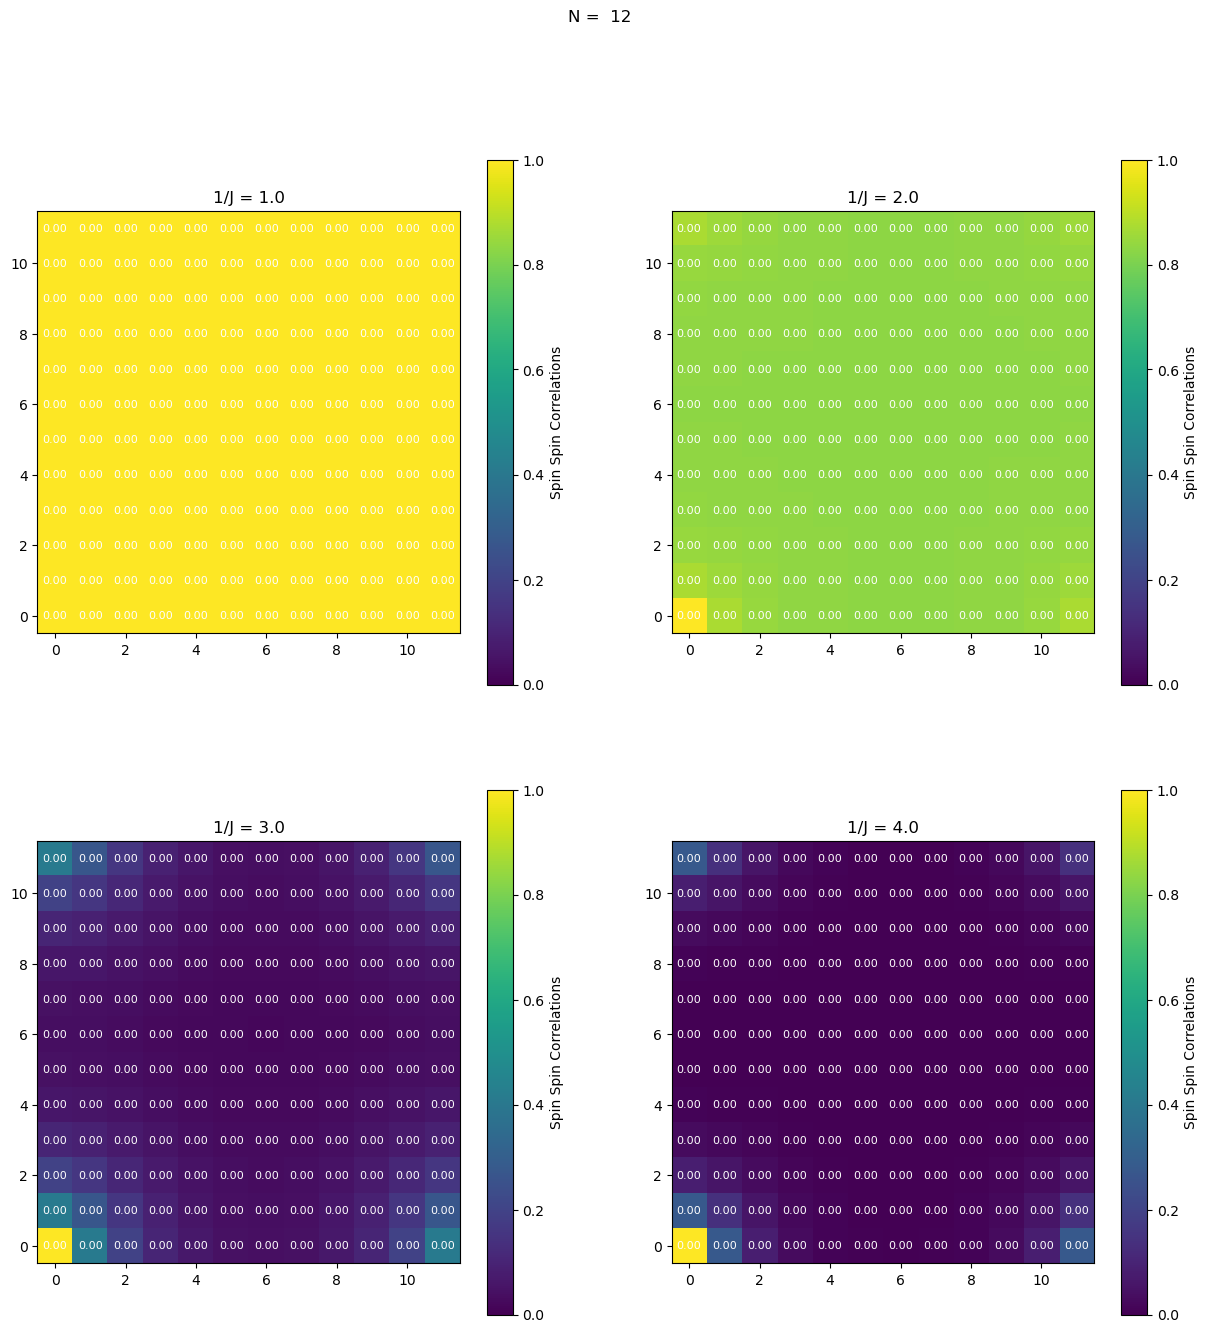

In [ ]:
for N in Ns:
    fig, axs = plt.subplots(2,2,figsize=(15,15))
    for i,ax in enumerate(axs.flat):
        data = bootstrap_dict[N][Js[i]][0]
        errors = bootstrap_dict[N][Js[i]][1]
        #plt.subplot(2, 2, n)
        heatmap = ax.imshow(data, cmap='viridis', origin='lower',vmin=0,vmax=1)
        plt.colorbar(heatmap, label="Spin Spin Correlations")
        ax.set_title(f"1/J = {iJs[i]}")


        #Annotate errors on the heatmap
        for i in range(data.shape[0]):
            for j in range(data.shape[1]):
                ax.text(j, i, f"{errors[i, j]:.2f}",
                ha='center', va='center', color='white', fontsize=8)

    fig.suptitle(f"N =  {N}")
    plt.show()

At low temperatures we are in the broken phase: All spins tend to be in the same direction and the spin-spin correlation is 1 for every distance. For $1/J = 2$ we are still in the broken phase but correlations are weaker. At higher temperatures the correlations are only weak and very local. This effect gets higher with even bigger temperatures. Due to the PBCs we have higher correlations at the boundaries but this has no physical meaning.

The white numbers indicate the errors and tend to be very small for 1000 bootstrapping samples and 10**5 configurations. With less configurations we obtained a bigger error. Note that the error are only rounded after the second digit and not really 0.

# Exercise 4: The Dynamical Exponent

In [ ]:
def derivative(series):
    n = len(series)
    dev = np.zeros(n)
    for i in range(n):
        tmp = series[(i+1)%n]-series[i]
        if tmp == 0:
            dev[i] = None   #call this None because we will later divide by this.
        else:
            dev[i] = tmp

    return dev


def compute_xi(correlation):
    correlation1d = correlation[0,:]
    return -correlation1d/derivative(correlation1d)


# Test $\xi$ function:

In [ ]:
test = compute_xi(bootstrap_dict[12][0.25][0]) #Choose N=12 and 1/J=4 as a test ensemble
ξ = test[int(N/4)]
print(test)
print(r'The true xi is',ξ)

[ 1.38650142  1.43972084  1.50459424  1.60653545  1.59242341  2.94473353
 -1.94473353 -0.59242341 -0.60653545 -0.50459424 -0.43972084 -0.38650142]
The true xi is 1.6065354453637475


In [ ]:
ξs = []
τs = []

for N in Ns:
    for J in Js:
        if auto_times[N][J][0] < steps:
            ξs.append(compute_xi(bootstrap_dict[N][J][0])[int(N/4)]) # Take middle value
            τs.append(auto_times[N][J][0])
print(ξs)
print(τs)

[43.094084957708375, 4.8153177851939954, 2.4152018633874457, 105.67296790466148, 2.7500163638109054, 1.5850466501397535, 283.4317405683385, 2.4912721795114225, 1.6065354453637475]
[149.91029620220874, 11.657136225814373, 3.4456720940934864, 7861.066706945977, 12.041488234462555, 3.4439077238573073, 12419.77694386488, 13.299975302561535, 3.5574715760771465]


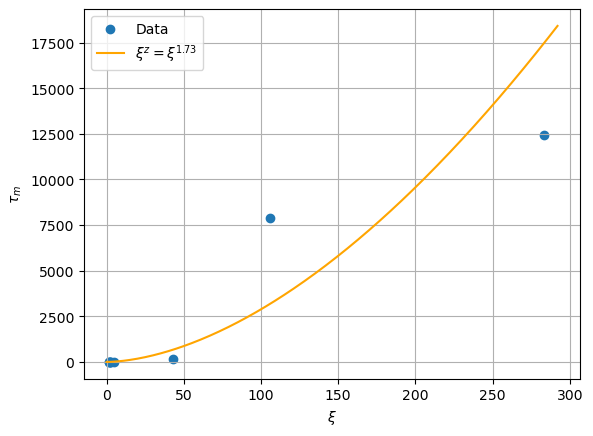

In [ ]:
plt.scatter(ξs,τs,label="Data")
xs = np.arange(int(max(ξs))+10)
z=1.73
ys = xs**z
plt.plot(xs,ys,color="orange",label = r"$\xi^z = \xi^{1.73}$")
plt.xlabel(r'$\xi $')
plt.ylabel(r'$\tau_m$')
plt.ylim()
plt.grid()
plt.legend()
plt.show()


To get a physical meaningful picture we excluded the ensembles in which the autocorrelation time was bigger than the number of drawn configurations. because a calcuation of the autocorrelation time was not possible. For the rest of the ensembles we added a polynomial to the plot with z = 1.73 as it fits best to our data from eyesight. Still they don't fit well to each other, but in general with increasing correlation length we get increasing autocorrelation time.